<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">
 
# Ensembles and Random Forests
 
_Author: Joseph Nelson (DC)_<br>
_Updated: B Rhodes (DC)_

*Adapted from Chapter 8 of [An Introduction to Statistical Learning](http://www-bcf.usc.edu/~gareth/ISL/)*

---

## Learning Objectives

Students will be able to:

- Understand how and why decision trees can be improved using bagging and random forests.
- Build random forest models for classification and regression.
- Know how to extract the most important predictors in a random forest model.


## Lesson Guide
- [Introduction](#introduction)
- [Part 1: Manual Ensembling](#part-one)
- [Part 2: Bagging](#part-two)
    - [Manually Implementing Bagged Decision Trees](#manual-bagged)
    - [Bagged Decision Trees in `scikit-learn`](#manual-sklearn)
    - [Estimating Out-of-Sample Error](#oos-error)
    
    
- [Part 3: Random Forests](#part-three)
- [Part 4: Building and Tuning Decision Trees and Random Forests](#part-four)
    - [Optional: Predicting Salary With a Decision Tree](#decision-tree)
    - [Predicting Salary With a Random Forest](#random-forest-demo)
    - [Comparing Random Forests With Decision Trees](#comparing)
    
    
- [Optional: Tuning Individual Parameters](#tuning)
- [Summary](#summary)

![](../assets/bagging_boosting.png)

In [1]:
# standard imports
import pandas as pd
import numpy as np # already imported

# sklearn imports
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree
from sklearn.ensemble import BaggingRegressor, BaggingClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics

from sklearn.datasets import load_iris

import matplotlib.pyplot as plt

<a id="introduction"></a>
## Introduction

### What is Ensembling?

**Ensemble learning (or "ensembling")** is the process of combining several predictive models in order to produce a combined model that is more accurate than any individual model. For example, given predictions from several models we could:

- **Regression:** Take the average of the predictions.
- **Classification:** Take a vote and use the most common prediction.

For ensembling to work well, the models must be:

- **Accurate:** They outperform the null model.
- **Independent:** Their predictions are generated using different processes.

**The big idea:** If you have a collection of individually imperfect (and independent) models, the "one-off" mistakes made by each model are probably not going to be made by the rest of the models, and thus the mistakes will be discarded when you average the models.

There are two basic **methods for ensembling:**

- Manually ensembling your individual models.
- Using a model that ensembles for you.

<a id="part-one"></a>
## Part 1: Manual Ensembling

What makes an effective manual ensemble?

- Different types of **models**.
- Different combinations of **features**.
- Different **tuning parameters**.

![Machine learning flowchart](../assets/crowdflower_ensembling.jpg)

*Machine learning flowchart created by the [winner](https://github.com/ChenglongChen/Kaggle_CrowdFlower) of Kaggle's [CrowdFlower competition](https://www.kaggle.com/c/crowdflower-search-relevance)*.

### Comparing Manual Ensembling With a Single Model Approach

**Advantages of manual ensembling:**

- It increases predictive accuracy.
- It's easy to get started.

**Disadvantages of manual ensembling:**

- It decreases interpretability.
- It takes longer to train.
- It takes longer to predict.
- It is more complex to automate and maintain.
- Small gains in accuracy may not be worth the added complexity.

<a id="part-two"></a>
## Part 2: Bagging

The primary weakness of **decision trees** is that they don't tend to have the best predictive accuracy. This is partially because of **high variance**, meaning that different splits in the training data can lead to very different trees.

**Bagging** is a general-purpose procedure for reducing the variance of a machine learning method but is particularly useful for decision trees. Bagging is short for **bootstrap aggregation**, meaning the aggregation of bootstrap samples.

A **bootstrap sample** is a random sample with replacement. So, it has the same size as the original sample but might duplicate some of the original observations.

[Bootstrapping](https://en.wikipedia.org/wiki/Bootstrapping) is a very common statistical technique that allows us to improve on certain statistical-modeling methods such as the decision tree.

- Used to quantify uncertainty of an parameter estimate or model.
- Allows us to emulate the process of obtaining new samples.
- Sampling is performed with replacement.

<br></br>
<center><img src='https://www.researchgate.net/profile/Paola_Galdi/publication/322179244/figure/fig2/AS:588191077777408@1517247089079/An-example-of-bootstrap-sampling-Since-objects-are-subsampled-with-replacement-some.png' alt="bootstrap" width="1000"/></center>

In [2]:
# Set a seed for reproducibility.
np.random.seed(7)

# Create an array of 1 through 11.
nums = np.arange(1, 11)
print(nums)

# Sample that array 10 times with replacement.
print(np.random.choice(a=nums, size=10, replace=True))

[ 1  2  3  4  5  6  7  8  9 10]
[ 5 10  7  4  4  8  8 10  8  9]


We've already learned that trees can *suffer from high variance*. 
- <b>B</b>ootstrap <b>agg</b>regation, or '<b>bagg</b>ing', is a *general-purpose procedure* for reducing the variance of a statistical model, which happens to be particularly useful and frequently used in the context of decision trees.

**Bagging** simply leverages the fact that *averaging a set of observations reduces variance*. 

<center><img src='https://upload.wikimedia.org/wikipedia/commons/thumb/c/c8/Ensemble_Bagging.svg/1280px-Ensemble_Bagging.svg.png' alt="bagging" width="900"/></center>

- Logically, then, one way to reduce variance (and increase prediction accuracy) is to:
    1. Take many, repeated training sets from the population 
    2. Build a separate prediction model using each training set 
    3. Average the resulting predictions

- For a **regression** problem, the outputs of individual models can literally be *averaged* to obtain the output of the ensemble model. 
- For a **classification** problem, the class outputted by each model can be seen as a *vote* and the class that receives the majority of the votes is returned by the ensemble model.


**How does bagging work (for decision trees)?**

1. Grow B trees using B bootstrap samples from the training data.
2. Train each tree on its bootstrap sample and make predictions.
3. Combine the predictions:
    - Average the predictions for **regression trees**.
    - Take a vote for **classification trees**.

Notes:

- **Each bootstrap sample** should be the same size as the original training set. (It may contain repeated rows.)
- **B** should be a large enough value that the error seems to have "stabilized".
- The trees are **grown deep** so that they have low bias/high variance.

Bagging increases predictive accuracy by **reducing the variance**, similar to how cross-validation reduces the variance associated with train/test split (for estimating out-of-sample error) by splitting many times an averaging the results.

<a id="manual-bagged"></a>
## Manually Implementing Bagged Decision Trees (with B=10)

#### Preprocess the dataset

In [3]:
# Read in and prepare the vehicle training data.

path = '../data/vehicles_train.csv'
train_vehicles_df = pd.read_csv(path)
# it's a dataset with 14 cars!
train_vehicles_df.shape

(14, 5)

In [4]:
# Read in and prepare the vehicle testing data.
path = '../data/vehicles_test.csv'
test_vehicles_df = pd.read_csv(path)
test_vehicles_df['vtype'] = test_vehicles_df['vtype'].map({'car':0, 'truck':1})
test_vehicles_df

,price,year,miles,doors,vtype
0,3000,2003,130000,4,1
1,6000,2005,82500,4,0
2,12000,2010,60000,2,0


In [5]:
# there are 5 columns describing the cars
train_vehicles_df.sample(6)

,price,year,miles,doors,vtype
1,14000,2010,30000,2,car
5,4000,2006,124000,2,car
2,13000,2010,73500,4,car
3,9500,2009,78000,4,car
11,5000,2001,62000,4,car
13,1300,1997,138000,4,car


In [6]:
# one of the variables is a string object
train_vehicles_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   price   14 non-null     int64 
 1   year    14 non-null     int64 
 2   miles   14 non-null     int64 
 3   doors   14 non-null     int64 
 4   vtype   14 non-null     object
dtypes: int64(4), object(1)
memory usage: 688.0+ bytes


**Questions**:
1. What is our target variable?
2. What type of model should we use?

In [7]:
# map the categorical feature to a numerical one.
train_vehicles_df['vtype'] = train_vehicles_df['vtype'].map({'car':0, 'truck':1})
train_vehicles_df.head(2)

,price,year,miles,doors,vtype
0,22000,2012,13000,2,0
1,14000,2010,30000,2,0


#### Build a single decision tree

In [8]:
# Instantiate the decision tree estimator.
treereg = DecisionTreeRegressor(max_depth=None, random_state=123)
treereg

DecisionTreeRegressor(random_state=123)

In [9]:
len(train_vehicles_df)

14

In [10]:
train_vehicles_df.iloc[:, 0]

0     22000
1     14000
2     13000
3      9500
4      9000
5      4000
6      3000
7      2000
8      3000
9      1900
10     2500
11     5000
12     1800
13     1300
Name: price, dtype: int64

In [11]:
# split the data into training & testing
X_train = train_vehicles_df.iloc[:, 1:]
y_train = train_vehicles_df.iloc[:, 0]

In [12]:
# Define testing data: there are 3 cars in the testing dataset
X_test = test_vehicles_df.iloc[:, 1:]
y_test = test_vehicles_df.iloc[:, 0]
X_test

,year,miles,doors,vtype
0,2003,130000,4,1
1,2005,82500,4,0
2,2010,60000,2,0


In [13]:
# and we know the actual price of those 3 cars 
list(y_test)

[3000, 6000, 12000]

In [14]:
# fit on the training data, and predict on the testing data
treereg.fit(X_train, y_train)
y_pred = treereg.predict(X_test)
y_pred

array([ 4000.,  5000., 14000.])

In [15]:
# evaluate your model
np.sqrt(metrics.mean_squared_error(y_test, y_pred))

1414.213562373095

#### Now build 10 decision trees, using bootstrap samples, and average them

In [16]:
# Set a seed for reproducibility.
np.random.seed(123)

# get the total number of observations.
size = train_vehicles_df.shape[0]
size


14

In [17]:
# Create ten (10) bootstrap samples. These will be used to select rows from the DataFrame.
samples = [np.random.choice(a=size, size=size, replace=True) for _ in range(1, 11)]
samples

[array([13,  2, 12,  2,  6,  1,  3, 10, 11,  9,  6,  1,  0,  1]),
 array([ 9,  0,  0,  9,  3, 13,  4,  0,  0,  4,  1,  7,  3,  2]),
 array([ 4,  7,  2,  4,  8, 13,  0,  7,  9,  3, 12, 12,  4,  6]),
 array([ 1,  5,  6, 11,  2,  1, 12,  8,  3, 10,  5,  0, 11,  2]),
 array([10, 10,  6, 13,  2,  4, 11, 11, 13, 12,  4,  6, 13,  3]),
 array([10,  0,  6,  4,  7, 11,  6,  7,  1, 11, 10,  5,  7,  9]),
 array([ 2,  4,  8,  1, 12,  2,  1,  1,  3, 12,  5,  9,  0,  8]),
 array([11,  1,  6,  3,  3, 11,  5,  9,  7,  9,  2,  3, 11,  3]),
 array([ 3,  8,  6,  9,  7,  6,  3,  9,  6, 12,  6, 11,  6,  1]),
 array([13, 10,  3,  4,  3,  1, 13,  0,  5,  8, 13,  6, 11,  8])]

In [18]:
# Show the rows for the first sample.
sample = train_vehicles_df.iloc[samples[0], :]
sample

,price,year,miles,doors,vtype
13,1300,1997,138000,4,0
2,13000,2010,73500,4,0
12,1800,1999,163000,2,1
2,13000,2010,73500,4,0
6,3000,2004,177000,4,0
1,14000,2010,30000,2,0
3,9500,2009,78000,4,0
10,2500,2003,190000,2,1
11,5000,2001,62000,4,0
9,1900,2003,160000,4,0


In [19]:
# Create an empty list for storing predicted price from each tree:
predictions = []

In [20]:
# Grow one tree for each of the 10 bootstrap samples and make predictions.
for sample in samples:
    X_train = train_vehicles_df.iloc[sample, 1:]
    y_train = train_vehicles_df.iloc[sample, 0]
    treereg.fit(X_train, y_train)
    y_pred = treereg.predict(X_test)
    predictions.append(y_pred)

In [21]:
# Convert predictions from list to NumPy array.
predictions = np.array(predictions)
predictions

array([[ 1300.,  5000., 14000.],
       [ 1300.,  1300., 13000.],
       [ 3000.,  3000., 13000.],
       [ 4000.,  5000., 13000.],
       [ 1300.,  5000., 13000.],
       [ 4000.,  5000., 14000.],
       [ 4000.,  4000., 13000.],
       [ 4000.,  5000., 13000.],
       [ 3000.,  5000.,  9500.],
       [ 4000.,  5000.,  9000.]])

In [22]:
# for each of the 3 testing cars, average the 10 predictions.
np.mean(predictions, axis=0)

array([ 2990.,  4330., 12450.])

In [23]:
# compare those averaged predictions to the true labels.
list(y_test)

[3000, 6000, 12000]

In [24]:
# Calculate RMSE for the averaged testing data. Notice the improvement!
y_pred = np.mean(predictions, axis=0)
np.sqrt(metrics.mean_squared_error(y_test, y_pred))

998.5823284370031

<a id="manual-sklearn"></a>
## Bagged Decision Trees in `scikit-learn` (with B=500)

In [25]:
# Define the training and testing sets. (we did this earlier, so this is repeat code!)
X_train = train_vehicles_df.iloc[:, 1:]
y_train = train_vehicles_df.iloc[:, 0]
X_test = test_vehicles_df.iloc[:, 1:]
y_test = test_vehicles_df.iloc[:, 0]

In [26]:
# Instandiate BaggingRegressor 
bagreg = BaggingRegressor(DecisionTreeRegressor(), n_estimators=10, bootstrap=True, oob_score=True, random_state=1)
# note: we use DecisionTreeRegressor as the "base estimator", and keep it to 10 like before.

In [27]:
# Fit and predict.
bagreg.fit(X_train, y_train)
y_pred = bagreg.predict(X_test)
y_pred

array([ 3720.,  4600., 11950.])

In [28]:
# Calculate RMSE. it's about the same as before.
np.sqrt(metrics.mean_squared_error(y_test, y_pred))

909.3770761717423

What happens if we increase the number of estimatros from 10 to 500?

In [29]:
# RMSE is reduced!
bagreg = BaggingRegressor(DecisionTreeRegressor(), n_estimators=500, bootstrap=True, oob_score=True, random_state=1)
bagreg.fit(X_train, y_train)
y_pred = bagreg.predict(X_test)
np.sqrt(metrics.mean_squared_error(y_test, y_pred))

673.9913550385247

<a id="oos-error"></a>
## Estimating Out-of-Sample Error

For bagged models, out-of-sample error can be estimated without using **train/test split** or **cross-validation**!

For each tree, the **unused observations** are called "out-of-bag" observations.

In [30]:
# Show the first bootstrap sample.
samples[0]

array([13,  2, 12,  2,  6,  1,  3, 10, 11,  9,  6,  1,  0,  1])

In [31]:
# Show the "in-bag" observations for each sample.
for sample in samples:
    print(set(sample))

{0, 1, 2, 3, 6, 9, 10, 11, 12, 13}
{0, 1, 2, 3, 4, 7, 9, 13}
{0, 2, 3, 4, 6, 7, 8, 9, 12, 13}
{0, 1, 2, 3, 5, 6, 8, 10, 11, 12}
{2, 3, 4, 6, 10, 11, 12, 13}
{0, 1, 4, 5, 6, 7, 9, 10, 11}
{0, 1, 2, 3, 4, 5, 8, 9, 12}
{1, 2, 3, 5, 6, 7, 9, 11}
{1, 3, 6, 7, 8, 9, 11, 12}
{0, 1, 3, 4, 5, 6, 8, 10, 11, 13}


In [32]:
# Show the "out-of-bag" observations for each sample.
for sample in samples:
    print(sorted(set(range(14)) - set(sample)))

[4, 5, 7, 8]
[5, 6, 8, 10, 11, 12]
[1, 5, 10, 11]
[4, 7, 9, 13]
[0, 1, 5, 7, 8, 9]
[2, 3, 8, 12, 13]
[6, 7, 10, 11, 13]
[0, 4, 8, 10, 12, 13]
[0, 2, 4, 5, 10, 13]
[2, 7, 9, 12]


**Calculating "out-of-bag error:"**

1. For each observation in the training data, predict its response value using **only** the trees in which that observation was out-of-bag. Average those predictions (for regression) or take a vote (for classification).
2. Compare all predictions to the actual response values in order to compute the out-of-bag error.

When B is sufficiently large, the **out-of-bag error** is an accurate estimate of **out-of-sample error**.

In [33]:
# Compute the out-of-bag R-squared score (not MSE, unfortunately) for B=500.
bagreg.oob_score_

0.7662607997982768

### Estimating Feature Importance

Bagging increases **predictive accuracy** but decreases **model interpretability** because it's no longer possible to visualize the tree to understand the importance of each feature.

However, we can still obtain an overall summary of **feature importance** from bagged models:

- **Bagged regression trees:** Calculate the total amount that **MSE** decreases due to splits over a given feature, averaged over all trees
- **Bagged classification trees:** Calculate the total amount that **Gini index** decreases due to splits over a given feature, averaged over all trees

<a id="part-three"></a>
## Part 3: Random Forests

Random Forests offer a **slight variation on bagged trees** with even better performance.

<center><img src='https://dsc-spidal.github.io/harp/img/4-5-1.png' alt="random forest" width="700"/></center>

<div style="text-align: right">Image source: <a href="https://dsc-spidal.github.io/harp/img/4-5-1.png">dsc-spidal.github</a></div>

Just like in bagging, we build some number of decision trees on bootstrapped training samples.

- Exactly like bagging, we create an ensemble of decision trees using bootstrapped samples of the training set.
- However, when building each tree, each time a split is considered, a **random sample of m features** is chosen as split candidates from the **full set of p features**. The split is only allowed to use **one of those m features**.
    - A new random sample of features is chosen for **every single tree at every single split**.
    - For **classification**, m is typically chosen to be the square root of p.
    - For **regression**, m is typically chosen to be somewhere between p/3 and p.

What's the point?

- Suppose there is **one very strong feature** in the data set. When using bagged trees, most of the trees will use that feature as the top split, resulting in an ensemble of similar trees that are **highly correlated**.
- Averaging highly correlated quantities does not significantly reduce variance (which is the entire goal of bagging).
- By randomly leaving out candidate features from each split, **random forests "decorrelate" the trees** to the extent that the averaging process can reduce the variance of the resulting model.
- Another way of looking at it is that sometimes one or two strong features dominate every tree in bagging, resulting in essentially the same tree as every predictor. (This is what was meant when saying the trees could be highly correlated.) By using a subset of features to generate each tree, we get a wider variety of predictive trees that do not all use the same dominant features.

#### Random Forest Algorithm  

1. Take a bootstrap sample of the dataset   

2. Train a decision tree on the bootstrap sample

    - For each split/feature selection, only evaluate a limited number of features to find the best one

3. Repeat this for $n$ trees  

4. Output the class that is the mode of the classes (classification) or mean prediction (regression) of the $n$ individual trees

Random forest models are one of the most widespread classifiers used.

#### Advantages
- Easy to tune
- Built-in protection against overfitting
- Non-linear
- Built-in interaction effects

#### Disadvantages
- *Slow*
- Black-box
- No “coefficients” (harder to explain)


<a id="part-four"></a>
## Part 4: Building and Tuning Decision Trees and Random Forests

In this section, we will implement random forests in scikit-learn.

- Major League Baseball player data from 1986-87: [data](https://github.com/justmarkham/DAT8/blob/master/data/hitters.csv), [data dictionary](https://cran.r-project.org/web/packages/ISLR/ISLR.pdf) (page 7)
- Each observation represents a player.
- **Goal:** Predict player salary.

### Preparing the Data

In [34]:
# Read in the data.
path ='../data/hitters.csv'
hitters_df = pd.read_csv(path)
hitters_df.shape


(322, 20)

In [35]:
# any missing data?
hitters_df.isnull().sum().sort_values(ascending=False).head()

Salary     59
AtBat       0
Hits        0
Errors      0
Assists     0
dtype: int64

In [36]:
# Remove rows with missing values.
hitters_df.dropna(inplace=True)

In [37]:
# take a look.
hitters_df.head(3)

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N


#### Side note: Encoding categorical variables 

In [38]:
# three variables are dtype "object". what do we do with these?
hitters_df.dtypes.sort_values(ascending=False)

NewLeague     object
Division      object
League        object
Salary       float64
Hits           int64
Errors         int64
Assists        int64
PutOuts        int64
CWalks         int64
CRBI           int64
AtBat          int64
CHmRun         int64
CHits          int64
CAtBat         int64
Years          int64
Walks          int64
RBI            int64
Runs           int64
HmRun          int64
CRuns          int64
dtype: object

In [39]:
# take a look at these 3 variables. They aren't usable.
hitters_df[['League','Division','NewLeague']].sample(4)

,League,Division,NewLeague
224,A,E,A
311,N,E,N
304,N,W,N
154,N,E,N


In [40]:
# Encode these categorical variables as integers using 'pd.factorize'
hitters_df['League'] = pd.factorize(hitters_df['League'])[0]
hitters_df['Division'] = pd.factorize(hitters_df['Division'])[0]
hitters_df['NewLeague'] = pd.factorize(hitters_df['NewLeague'])[0]
hitters_df[['League','Division','NewLeague']].sample(4)

,League,Division,NewLeague
76,0,0,1
96,1,1,1
240,1,0,1
50,1,0,1


#### Define features

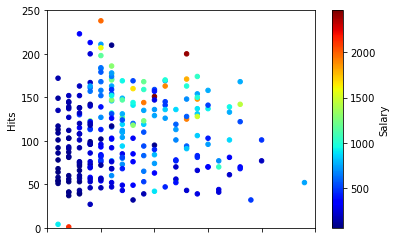

In [41]:
# Create a scatter plot of hits vs years, colored by salary
hitters_df.plot(kind='scatter', x='Years', y='Hits', c='Salary', colormap='jet', xlim=(0, 25), ylim=(0, 250));

In [42]:
# Define features: Exclude career statistics (which start with "C") and the response (salary).
feature_cols = hitters_df.columns[hitters_df.columns.str.startswith('C') == False].drop('Salary')
feature_cols

Index(['AtBat', 'Hits', 'HmRun', 'Runs', 'RBI', 'Walks', 'Years', 'League',
       'Division', 'PutOuts', 'Assists', 'Errors', 'NewLeague'],
      dtype='object')

In [43]:
# Define X and y.
X = hitters_df[feature_cols]
y = hitters_df['Salary']

<a id="decision-tree"></a>
## Optional: Predicting Salary With a Decision Tree

Let's first recall how we might predict salary using a single decision tree.

We'll first find the best **max_depth** for a decision tree using cross-validation:

In [44]:
# List of values to try for max_depth:
max_depth_range = list(range(1, 21))

# List to store the average RMSE for each value of max_depth:
RMSE_scores = []

# Use 10-fold cross-validation with each value of max_depth.
for depth in max_depth_range:
    treereg = DecisionTreeRegressor(max_depth=depth, random_state=1)
    MSE_scores = cross_val_score(treereg, X, y, cv=10, scoring='neg_mean_squared_error')
    RMSE_scores.append(np.mean(np.sqrt(-MSE_scores)))

Why are we using negative mean squared error? https://www.kaggle.com/questions-and-answers/154600

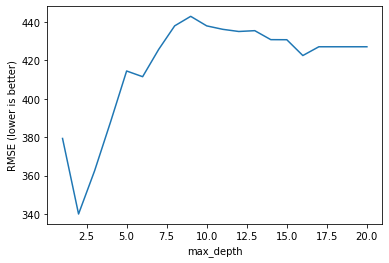

In [45]:
# Plot max_depth (x-axis) versus RMSE (y-axis).
plt.plot(max_depth_range, RMSE_scores);
plt.xlabel('max_depth');
plt.ylabel('RMSE (lower is better)');

In [46]:
# Show the best RMSE and the corresponding max_depth.
sorted(zip(RMSE_scores, max_depth_range))[0]

(340.034168704752, 2)

In [47]:
# max_depth=2 was best, so fit a tree using that parameter.
treereg = DecisionTreeRegressor(max_depth=2, random_state=1)
treereg.fit(X, y)

DecisionTreeRegressor(max_depth=2, random_state=1)

In [48]:
# Compute feature importances.
pd.DataFrame({'feature':feature_cols, 'importance':treereg.feature_importances_}).sort_values(by='importance', ascending=False)

,feature,importance
1,Hits,0.511609
6,Years,0.488391
0,AtBat,0.000000
2,HmRun,0.000000
3,Runs,0.000000
4,RBI,0.000000
5,Walks,0.000000
7,League,0.000000
8,Division,0.000000
9,PutOuts,0.000000


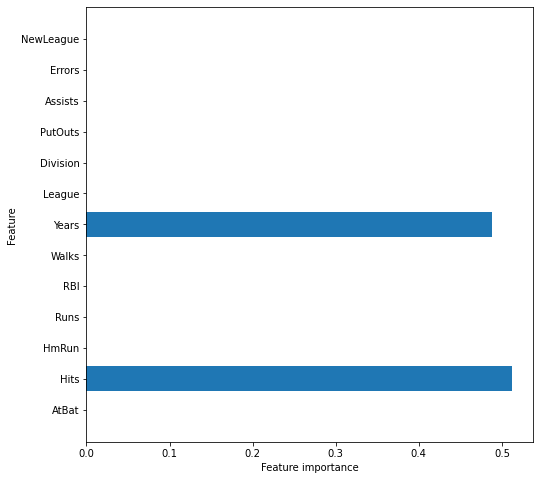

In [49]:
# plot the important features
def plot_feature_importances(model):
    n_features = X.shape[1]
    plt.figure(figsize=(8,8))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X.columns.values) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')

plot_feature_importances(treereg)

<a id="random-forest-demo"></a>
## Predicting Salary With a Random Forest

In [50]:
#  n_estimators=150 is sufficiently large for this size dataset.
rfreg = RandomForestRegressor(n_estimators=150, max_features=5, oob_score=True, random_state=1)
rfreg.fit(X, y)

RandomForestRegressor(max_features=5, n_estimators=150, oob_score=True,
                      random_state=1)

In [51]:
# Compute the out-of-bag R-squared score.
print((rfreg.oob_score_))

0.5174330883603366


In [52]:
# Find the average RMSE.
scores = cross_val_score(rfreg, X, y, cv=10, scoring='neg_mean_squared_error')
np.mean(np.sqrt(-scores))

295.47994138792376

"Feature importance" computes the average reduction in impurity across all trees in the forest due to each feature. That is, features that tend to split nodes closer to the root of a tree will result in a larger importance value.. The most important variables are ranked by how much they reduce the error in the predictions.

In [53]:
# compute the relative importances of each feature
print(feature_cols)
rfreg.feature_importances_

Index(['AtBat', 'Hits', 'HmRun', 'Runs', 'RBI', 'Walks', 'Years', 'League',
       'Division', 'PutOuts', 'Assists', 'Errors', 'NewLeague'],
      dtype='object')


array([0.09344587, 0.14409643, 0.04160822, 0.07961091, 0.13320674,
       0.13935539, 0.22400272, 0.00443928, 0.00853554, 0.06213041,
       0.02866734, 0.0369007 , 0.00400047])

In [54]:
# Turn that into a dataframe
pd.DataFrame({'feature':feature_cols, 
              'importance':rfreg.feature_importances_}).sort_values(by='importance', ascending=False)

,feature,importance
6,Years,0.224003
1,Hits,0.144096
5,Walks,0.139355
4,RBI,0.133207
0,AtBat,0.093446
3,Runs,0.079611
9,PutOuts,0.062130
2,HmRun,0.041608
11,Errors,0.036901
10,Assists,0.028667


#### Reducing X to its Most Important Features

What we would do here is take the top 15 most important features for example, and train our random forest model again using only those, effectively performing a feature selection step and discarding more than 30 pretty useless variables.

In [55]:
# Check the shape of X.
X.shape

(263, 13)

** It important not to select features before separating your train from your test otherwise you are selecting features based on all known observations and introducing more of the information in the test data to the model when you fit it on the training data. **

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 89)

In [57]:
# Fit the model on only the train data
rfreg = RandomForestRegressor(n_estimators=150, max_features=5, oob_score=True, random_state=1)
rfreg.fit(X_train, y_train)

RandomForestRegressor(max_features=5, n_estimators=150, oob_score=True,
                      random_state=1)

In [58]:
# Set a threshold for which features to include.

print(SelectFromModel(rfreg, threshold='mean', prefit=True).transform(X_train).shape)
print(SelectFromModel(rfreg, threshold='median', prefit=True).transform(X_train).shape)

(197, 5)
(197, 7)


Using the fit model and the features from the train data to transform the test data

In [59]:
# Create a new feature matrix that only includes important features.

X_important =  SelectFromModel(rfreg, threshold='mean', prefit=True).transform(X_test)

In [60]:
# Check the RMSE for a random forest that only includes important features.
rfreg = RandomForestRegressor(n_estimators=150, max_features=3, random_state=1)

scores = cross_val_score(rfreg, X_important, y_test, cv=10, scoring='neg_mean_squared_error')
np.mean(np.sqrt(-scores))

314.39051968316204

In this case, the error decreased slightly. Often parameter tuning is required to achieve optimal results.

<a id="comparing"></a>
## Comparing Random Forests With Decision Trees

**Advantages of random forests:**

- Their performance is competitive with the best supervised learning methods.
- They provide a more reliable estimate of feature importance.
- They allow you to estimate out-of-sample error without using train/test split or cross-validation.

**Disadvantages of random forests:**

- They are less interpretable.
- They are slower to train.
- They are slower to predict.

![Machine learning flowchart](../assets/driver_ensembling.png)

*Machine learning flowchart created by the [second-place finisher](http://blog.kaggle.com/2015/04/20/axa-winners-interview-learning-telematic-fingerprints-from-gps-data/) of Kaggle's [Driver Telematics competition](https://www.kaggle.com/c/axa-driver-telematics-analysis)*.

<a id='boosting'></a>
### Boosting
---

<img style="float: right" src='https://media0.giphy.com/media/cRH5deQTgTMR2/giphy.gif' alt="turbo boost" width="350"/>

- Works for many other statistical learning methods
- Trees are grown sequentially on the residuals of the prior tree
- Iteratively learns weak classifiers and adds them to create a strong classifier
- Parallelisation can _not_ be applied, must be performed serially.

<center><img src='https://upload.wikimedia.org/wikipedia/commons/thumb/b/b5/Ensemble_Boosting.svg/1920px-Ensemble_Boosting.svg.png' alt="boosting" width="700"/></center>

While not limited to decision trees, boosting algorithms **consist of iteratively learning weak classifiers with respect to a distribution and adding them to a final strong classifier.**
- When they are added, they are typically weighted in some way that is usually related to the weak learners' accuracy.
- After a weak learner is added, the data weights are readjusted, known as "re-weighting". 
- Misclassified input data gain a higher weight and examples that are classified correctly lose weight.
- Thus, future weak learners focus more on the examples that previous weak learners misclassified.

## Quick Comparison of Ensemble Methods


In [61]:
# import dataset
iris = load_iris()

# split training/test data
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, random_state=7)
column_names = iris.feature_names
column_names

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

#### Decision Tree

In [62]:
# instantiate and fit model (tree)
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)

# evaluate model
clf.score(X_test, y_test)


0.9210526315789473

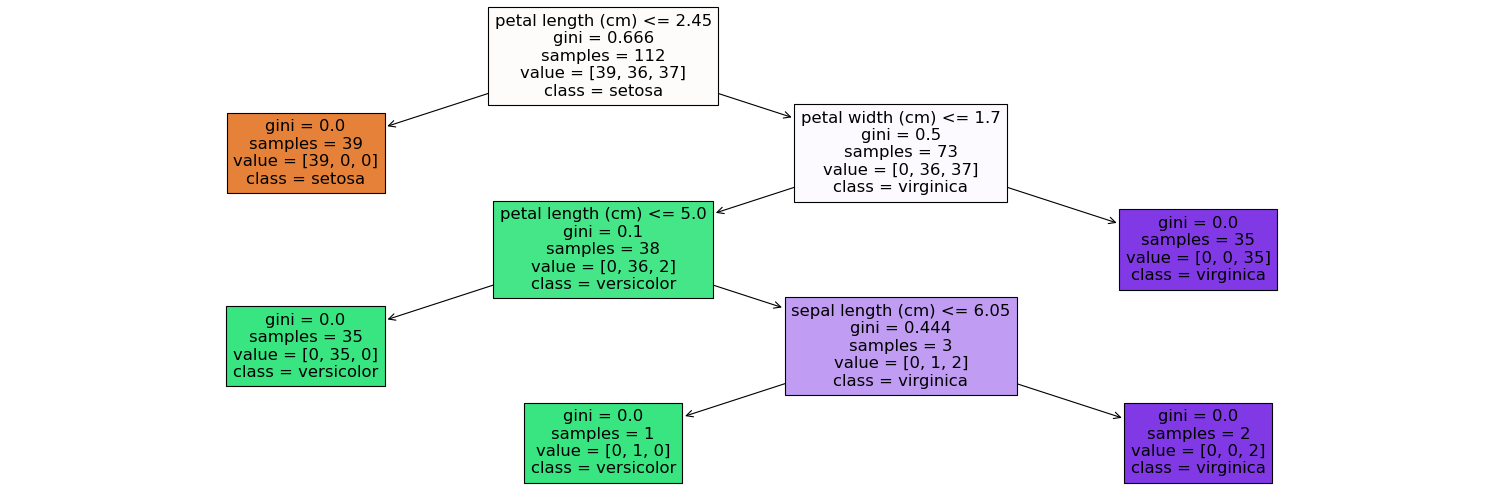

In [63]:
# visualize decision tree
plt.figure(num=None, figsize=(24, 8), dpi=80)
plot_tree(clf, feature_names=iris.feature_names, class_names=iris.target_names, filled=True);

##### Bagging

In [64]:
bagging = BaggingClassifier(base_estimator = DecisionTreeClassifier(),
                            n_estimators = 100, 
                            random_state = 0)

bagging.fit(X_train, y_train).score(X_test, y_test)


0.9210526315789473

##### Random Forest

In [65]:
rand_forest = RandomForestClassifier(n_estimators = 100, 
                            random_state = 0)

rand_forest.fit(X_train, y_train).score(X_test, y_test)

0.8947368421052632

##### AdaBoost

In [66]:
boosting = AdaBoostClassifier(n_estimators=100, random_state=0)
boosting.fit(X_train, y_train).score(X_test, y_test)

0.9473684210526315

<a id="tuning"></a>
## Optional: Tuning Individual Parameters

In [67]:
# instantiate RF Regressor

rfreg = RandomForestRegressor()
rfreg

RandomForestRegressor()

### Tuning n_estimators

One important tuning parameter is **n_estimators**, which represents the number of trees that should be grown. This should be a large enough value that the error seems to have "stabilized."

In [68]:
# List of values to try for n_estimators:
estimator_range = list(range(10, 310, 10))

# List to store the average RMSE for each value of n_estimators:
RMSE_scores = []

# Use five-fold cross-validation with each value of n_estimators (Warning: Slow!).
for estimator in estimator_range:
    rfreg = RandomForestRegressor(n_estimators=estimator, random_state=1)
    MSE_scores = cross_val_score(rfreg, X, y, cv=5, scoring='neg_mean_squared_error')
    RMSE_scores.append(np.mean(np.sqrt(-MSE_scores)))

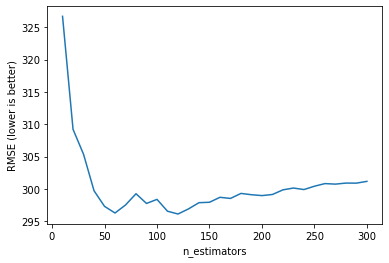

In [69]:
# Plot RMSE (y-axis) versus n_estimators (x-axis).

plt.plot(estimator_range, RMSE_scores);

plt.xlabel('n_estimators');
plt.ylabel('RMSE (lower is better)');

**In theory, the RMSE will continue to decrease and eventually level out.  Adding more estimators will neither (noticably)increase or decrease the RMSE (or other loss metric). However, introduction of noise can lead to random spikes as the ```n_estimators``` changes. This example is particularly interesting as after about 120 estimators the RMSE seems to steadily rise as more estimators are added.**

### Tuning max_features

The other important tuning parameter is **max_features**, which represents the number of features that should be considered at each split.

In [70]:
# List of values to try for max_features:
feature_range = list(range(1, len(feature_cols)+1))

# List to store the average RMSE for each value of max_features:
RMSE_scores = []

# Use 10-fold cross-validation with each value of max_features (Warning: Super slow!).
for feature in feature_range:
    rfreg = RandomForestRegressor(n_estimators=150, max_features=feature, random_state=1)
    MSE_scores = cross_val_score(rfreg, X, y, cv=10, scoring='neg_mean_squared_error')
    RMSE_scores.append(np.mean(np.sqrt(-MSE_scores)))

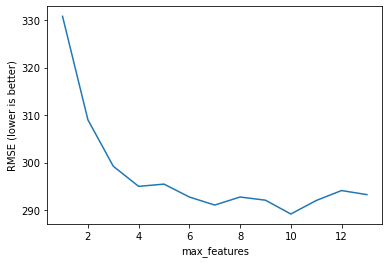

In [71]:
# Plot max_features (x-axis) versus RMSE (y-axis).

plt.plot(feature_range, RMSE_scores);

plt.xlabel('max_features');
plt.ylabel('RMSE (lower is better)');

In [72]:
# Show the best RMSE and the corresponding max_features.
sorted(zip(RMSE_scores, feature_range))

[(289.1877447560242, 10),
 (291.0716929366723, 7),
 (292.02632730329606, 11),
 (292.09386343132644, 9),
 (292.7622917789621, 8),
 (292.76263438242944, 6),
 (293.26394842228433, 13),
 (294.12619339631203, 12),
 (295.0059068537387, 4),
 (295.47994138792376, 5),
 (299.24041034975426, 3),
 (309.01217404490137, 2),
 (330.7795837651744, 1)]

<a id="hyper"></a>
## Hyperparameter Tuning

<a id="grid"></a>
### Grid Search
The traditional way of performing hyperparameter optimization has been *grid search*, which is simply an exhaustive searching through a manually specified subset of the hyperparameter space of a learning algorithm.
- A grid search algorithm must be guided by some performance metric, typically measured by cross-validation on the training set.

#### For example, 
...to find the best values for the hyperparameters $A$ and $B$, grid search manually checks the performance of a learning algorithm with ***every possible combination*** of hyperparameters settings (i.e. the Cartesian product of $A$ and $B$), and returns the *best one*.

<center><img src='https://upload.wikimedia.org/wikipedia/commons/thumb/4/4e/Cartesian_Product_qtl1.svg/1280px-Cartesian_Product_qtl1.svg.png' alt="grid" width="700"/></center>

#### Let's try one...

In [73]:
# create a dictionary of all the parameter options 
parameters = dict([
                    ('criterion',['gini', 'entropy']),
                    ('max_depth',[4,6,8,12])
                  ])

print(parameters) 

{'criterion': ['gini', 'entropy'], 'max_depth': [4, 6, 8, 12]}


In [74]:
from sklearn.model_selection import GridSearchCV, cross_val_score

clf = DecisionTreeClassifier()

# conduct parameter optmization with pipeline
# create a grid search object
cv = GridSearchCV(clf, parameters)

# 'fit' the grid search
cv.fit(X_train, y_train)

# view the best parameters
print('Best Criterion:', cv.best_estimator_.get_params()['criterion'])
print('Best max_depth:', cv.best_estimator_.get_params()['max_depth'])

# use cross validation to evaluate model
CV_Result = cross_val_score(cv, X_test, y_test, cv=4, n_jobs=-1)
print(); print(CV_Result)

Best Criterion: gini
Best max_depth: 12

[0.8        0.8        0.77777778 0.77777778]


<a id="simulation"></a>
#### Grid Search Simulation
One of the main drawbacks to grid search is the time complexity of the algorithm.
- To get a better sense for how the duration changes as we increase the size of our input, let's run a simple comparison of a few different parameter grids.

In [75]:
# twice as large as original
parameters_2X = dict([
                    ('criterion',['gini', 'entropy']),
                    ('splitter',['best', 'random']),
                    ('max_depth',[4,6,8,12]),
                    ('min_samples_leaf',list(range(1,5)))
                  ])


# maybe 2.5X as large as original
parameters_2Xplus = dict([
                    ('criterion',['gini', 'entropy']),
                    ('splitter',['best', 'random']),
                    ('max_features',['auto', 'sqrt', 'log2']),
                    ('max_depth',[4,6,8,12]),
                    ('min_samples_leaf',list(range(1,5)))
                  ])

In [76]:
import time

def grid_time(parameters):
    start = time.time()
    cv = GridSearchCV(clf, parameters)  # instantiate the grid search
    cv.fit(X_train, y_train) # 'fit' the grid search
    end = time.time()
    return end - start

small_grid_time = grid_time(parameters)
med_grid_time = grid_time(parameters_2X)
large_grid_time = grid_time(parameters_2Xplus)

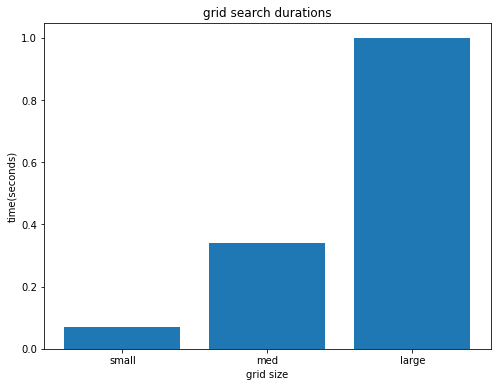

In [77]:
plt.figure(figsize=(8,6))
plt.bar([1,2,3],[small_grid_time,med_grid_time,large_grid_time])
plt.xticks([1,2,3],['small','med','large'])
plt.xlabel('grid size')
plt.ylabel('time(seconds)')
plt.title('grid search durations')
plt.show();

<a id="summary"></a>
## Summary

**Which model is best?** The best classifier for a particular task is task-dependent. In many business cases, interpretability is more important than accuracy. So, decision trees may be preferred. In other cases, accuracy on unseen data might be paramount, in which case random forests would likely be better (since they typically overfit less). 

Remember that every model is a tradeoff between bias and variance. Ensemble models attempt to reduce overfitting by reducing variance but increasing bias (as compared to decision trees). By making the model more stable, we necessarily make it fit the training data less accurately. In some cases this is desired (particularly if we start with lots of overfitting), but for more simply structured data a simple decision tree might be best.

---

**In this lesson:**

- We looked at ensemble models.

- We saw how decision trees could be extended using two ensemble techniques -- bagging and random forests.

- We looked at methods of evaluating feature importance and tuning parameters (e.g. gridsearch).